# **Advanced Level Construction Equipment Activity Detection: Use of Kinematic and Audio Data**

This notebook demonstrates a practical **advanced-level machine learning pipeline** (an “advanced course project library”) based on a hybrid kinematic-acoustic approach. It uses accelerometer, gyroscope, and audio data to detect multiple equipment activities and includes:

- Data loading and synchronization  
- Preprocessing steps (noise/outlier filtering, gravity removal, interpolation, normalization)  
- Feature extraction (Short-Time Fourier Transform)  
- Label assignment and data transformation  
- Model training (basic neural network)  
- Hyperparameter tuning (Keras Tuner)  
- Transfer learning demo (with ResNet50)  
- Sensitivity analysis, cross-validation, multiple metrics  

**Note:** This code specifically shows how to handle only a snippet of data from a CAT 259D for about 81 seconds, but it illustrates the type of advanced pipeline an instructor or student can build.  

**Data Source Notice:**  
The dataset used in this project is a small portion of a larger dataset originally used in the research paper:

*A Hybrid Kinematic-Acoustic System for Automated Activity Detection of Construction Equipment*  
by Behnam Sherafat, Abbas Rashidi, Yong-Cheol Lee, and Changbum R. Ahn  
*Sensors 2019, 19(19), 4286; https://doi.org/10.3390/s19194286*

For more detailed background and information on the original methodology, users are encouraged to read the above paper. However, **the approach implemented here is not an exact replication** of the method described in the publication, and includes variations tailored for educational use in the CyCon platform.


### **Imports and Setup**


  **Explanation:**

  - We import essential libraries for:
    - **Signal Processing**: `scipy.io`, `scipy.signal`
    - **Numerical/Scientific**: `numpy`, `pandas`
    - **Plotting**: `matplotlib`
    - **ML/AI**: `tensorflow` (Keras), `sklearn` (PCA, metrics, model selection)
    - **Hyperparameter Tuning**: `keras_tuner`

  - We use standard libraries for **downloading** and **in‑memory file handling**:
    - `requests` to fetch files directly from the web  
    - `io`       to load those fetched files into memory without writing to disk
  - These libraries allow us to load `.mat` files, process audio and sensor signals, build neural networks, and evaluate them with multiple metrics.
  - We define default URLs for your data (you can replace these with your own data).



In [1]:
import scipy.io
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from scipy.io import wavfile
from scipy import interpolate, signal
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input
import IPython

# Standard libraries for downloading and in‑memory file handling
import requests
import io

# For hyperparameter tuning (Keras Tuner)
try:
    import keras_tuner as kt
except ImportError:
    !pip install keras-tuner --quiet
    import keras_tuner as kt

# Additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

DEFAULT_LABEL_URL = "https://raw.githubusercontent.com/CyConProject/Course-Project-Libraries/main/Advanced/Construction_Equipment_Activity_Detection/Audio%20Kinematic%20Data/labels.csv"
DEFAULT_AUDIO_URL = "https://raw.githubusercontent.com/CyConProject/Course-Project-Libraries/main/Advanced/Construction_Equipment_Activity_Detection/Audio%20Kinematic%20Data/ZOOM0020_den.wav"
DEFAULT_MAT_URL   = "https://raw.githubusercontent.com/CyConProject/Course-Project-Libraries/main/Advanced/Construction_Equipment_Activity_Detection/Audio%20Kinematic%20Data/test2.mat"


### **1-A. `load_data` Function**

  **What It Does:**
  - Reads a MATLAB file (`.mat`) to extract:
    - **Accelerometer** data in `X`, `Y`, `Z`
    - **Gyroscope** data in `Vx`, `Vy`, `Vz`
    - **Timestamps** for accelerometer (`timestampAccel`) and angular (`timestampAng`) data
  - Calculates sampling rates (`fsAccel`, `fsAng`) based on timestamps.
  - Reads a WAV audio file and offsets it by `delay`, which accounts for any synchronization difference between the sensor data and the audio recording.
  - If `plot_data=True`, it plots raw acceleration signals as a quick diagnostic check.


  **Key Points:**
  - **Delay** is crucial for synchronizing audio with kinematic signals (sometimes audio starts later or earlier).
  - The delay value is derived by manually aligning spikes in both audio and vibration signals caused by a common event (i.e., equipment horn), so the start points match in time.
  - The function returns the sensor signals, their sampling rates, and the shifted audio array.

</details>

In [2]:
################################################################################
# 1-A. LOAD DATA
################################################################################
def load_data(mat_file: str = DEFAULT_MAT_URL,
              audio_file: str = DEFAULT_AUDIO_URL,
              delay=2.2244,
              plot_data=True):
    """
    Loads sensor data from .mat and audio data from .wav.
    'delay' is how much audio is offset relative to the sensor data.
    'plot_data' toggles basic plotting for demonstration.
    """
    if mat_file.startswith("http"):
      response = requests.get(mat_file)
      response.raise_for_status()
      mat_buffer = io.BytesIO(response.content)
      data = scipy.io.loadmat(mat_buffer)
    else:
      data = scipy.io.loadmat(mat_file)

    # Reading sensor data
    X = data["Ax"].flatten()
    Y = data["Ay"].flatten()
    Z = data["Az"].flatten()
    Vx = data["Vx"].flatten()
    Vy = data["Vy"].flatten()
    Vz = data["Vz"].flatten()

    timestampAccel = data["timestampAccel"].flatten()
    timestampAng   = data["timestampAng"].flatten()

    fsAccel = len(timestampAccel) / timestampAccel[-1]
    fsAng   = len(timestampAng) / timestampAng[-1]

    # Download .wav file if a URL is provided
    if audio_file.startswith("http"):
        response = requests.get(audio_file, stream=True)
        response.raise_for_status()
        audio_buffer = io.BytesIO(response.content)
        fsAudio, S_Audio = wavfile.read(audio_buffer)
    else:
        fsAudio, S_Audio = wavfile.read(audio_file)

    # Normalise audio to float
    S_Audio = S_Audio.astype(float)*3.0517578125e-05  # Map raw audio to float
    start_Audio = int(np.round(delay*fsAudio))
    S_Audio = S_Audio[start_Audio:]

    if plot_data:
        plt.figure(figsize=(8,6))
        fig, axs = plt.subplots(3, 1, figsize=(8, 6))
        axs[0].plot(X, linestyle='dotted')
        axs[0].set_ylabel('Accel X')
        axs[0].set_title('Raw Accel Data (Example)')
        axs[1].plot(Y, linestyle='dotted', color='red')
        axs[1].set_ylabel('Accel Y')
        axs[2].plot(Z, linestyle='dotted', color='green')
        axs[2].set_ylabel('Accel Z')
        axs[2].set_xlabel('Samples')
        plt.tight_layout()
        plt.show()

    return (X, Y, Z, Vx, Vy, Vz, fsAccel, fsAng, fsAudio, S_Audio)

### **1-B. `load_labels` Function**

  
  **What It Does:**
  - Simply loads a CSV file containing labeled segments of time.  
  - Each row in the CSV should have `[start_time, end_time, label]`, defining the ground-truth activity in that time range.


  **Why This Matters:**
  - We need ground-truth labels to train and evaluate the machine learning model.  
  - This function standardizes how labels are read into a `pandas` DataFrame for subsequent steps.
  - The labels were generated by reviewing synchronized video recordings, which served as a reference to manually identify and annotate distinct periods of activity across the audio and kinematic signals.



In [3]:
################################################################################
# 1-B. LOAD LABELS (CSV)
################################################################################
# Activity codes used in labels.csv  ────────────────
# 1 → Stop / Idle
# 2 → Arm / Shovel movement
# 3 → Maneuvering (forward / backward)
# 4 → Turning (right / left)

def load_labels(label_file: str = DEFAULT_LABEL_URL):
    """
    Reads a CSV with columns: start_time, end_time, label.
    Returns a DataFrame for advanced usage.
    """
    label_df = pd.read_csv(label_file)
    return label_df

### **1-C. `apply_labels` Function**

  
  **What It Does:**
  - Converts the table of labeled time intervals (`start_time`, `end_time`, `label`) into a **sample-by-sample** label array.
  - For each row in `label_df`, we calculate a start and end index based on the sampling frequency (`fs`) and fill that range in the `label_array` with the appropriate integer label.
  
  
  **Use Case:**
  - By the end, we have an integer label for each sample index in the final array. This helps us later assign labels to STFT frames or any other feature representation.



In [4]:
################################################################################
# 1-C. APPLY LABELS
################################################################################
def apply_labels(data_length, fs, label_df):
    """
    Convert the label_df [start_time, end_time, label] into a label array
    of length 'data_length'. Each index in the label array corresponds to a
    sample in the final processed dataset.
    """
    label_array = np.zeros(data_length, dtype='int32')

    for idx, row in label_df.iterrows():
        start_sec = row['start_time']
        end_sec   = row['end_time']
        lbl       = int(row['label'])

        start_idx = int(np.floor(start_sec * fs))
        end_idx   = int(np.floor(end_sec * fs))

        start_idx = max(0, start_idx)
        end_idx   = min(data_length, end_idx)

        label_array[start_idx:end_idx] = lbl

    return label_array

### **2. `preprocess_data` Function**


  **Key Steps:**

  1. **Remove Gravity**:  
     - Uses a simple low-pass filter approach (`kFilteringFactor` = 0.1). Each accelerometer reading is split into dynamic acceleration plus gravity.  
     - Subtracting the estimated gravity (`g1`, `g2`, `g3`) yields the true dynamic portion only.

  2. **Remove Outliers**:  
     - Implements a rolling-window approach. Points lying beyond ±3 standard deviations of the local mean are marked as outliers and replaced by `nan`, then filled forward/backward.

  3. **Resampling and Interpolation**:
     - Truncates signals so that each sensor has the same **time duration** `T`.  
     - Creates a new time base `xq` based on the **audio sampling rate** (the highest rate).  
     - Interpolates all sensor signals to match that time base, effectively “up-sampling” the kinematic data to the audio rate.
     - kinematic data (≈100 Hz) is *upsampled* to match the 44.1 kHz audio.  The paper showed that down‑sampling audio erased high‑frequency cues and hurt accuracy by ≈20 %.  Linear interpolation (`interp1d`) therefore preserves information while making feature‑fusion straightforward.

  4. **Normalization**:
     - Applies a standard z-score normalization:

$$ \frac{\text{signal} - \mu}{\sigma} $$
  5. **Plot** (optional):
     - Visual check of processed accelerometer signals.

  **Return Values**:
  - Returns all processed signals (`S_Audio`, `S_Ax`, `S_Ay`, etc.), the final audio sampling rate (`int(fsAudio)`), and the total truncated duration `T`.



In [5]:
################################################################################
# 2. PREPROCESS DATA
################################################################################
def preprocess_data(X, Y, Z, Vx, Vy, Vz, fsAccel, fsAng, fsAudio, S_Audio,
                    T_limit=120, plot_data=True, kFilteringFactor=0.1):
    """
    Removes gravity, filters outliers, interpolates signals, normalizes them, etc.
    'kFilteringFactor' can be varied for sensitivity analysis.
    """
    # 2.1 Remove gravity from accelerometer data
    g1 = g2 = g3 = 0
    Bx, By, Bz = np.zeros(len(X)), np.zeros(len(Y)), np.zeros(len(Z))

    for i in range(len(X)):
        g1 = (X[i] * kFilteringFactor) + (g1 * (1.0 - kFilteringFactor))
        g2 = (Y[i] * kFilteringFactor) + (g2 * (1.0 - kFilteringFactor))
        g3 = (Z[i] * kFilteringFactor) + (g3 * (1.0 - kFilteringFactor))
        Bx[i] = X[i] - g1
        By[i] = Y[i] - g2
        Bz[i] = Z[i] - g3

    # 2.2 Remove outliers
    def rolling_outlier_removal(signal_in, window=3):
        df_temp = pd.DataFrame(signal_in)
        r = df_temp.rolling(window=window)
        mps_up, mps_low = r.mean() + 3 * r.std(), r.mean() - 3 * r.std()
        df_temp.loc[~df_temp[0].between(mps_low[0], mps_up[0]), 0] = np.nan
        return df_temp[0].fillna(method='bfill').values

    S_Ax = rolling_outlier_removal(Bx)
    S_Ay = rolling_outlier_removal(By)
    S_Az = rolling_outlier_removal(Bz)

    # 2.3 Resampling
    T_A     = len(S_Audio)/fsAudio
    T_Accel = len(S_Ax)/fsAccel
    T_Ang   = len(Vx)/fsAng
    T       = min(T_limit, T_A, T_Accel, T_Ang)

    S_Ax = S_Ax[:int(np.floor(T*fsAccel))]
    S_Ay = S_Ay[:int(np.floor(T*fsAccel))]
    S_Az = S_Az[:int(np.floor(T*fsAccel))]

    S_Vx = Vx[:int(np.floor(T*fsAng))]
    S_Vy = Vy[:int(np.floor(T*fsAng))]
    S_Vz = Vz[:int(np.floor(T*fsAng))]

    S_Audio = S_Audio[:int(np.floor(T*fsAudio))]

    xA = np.linspace(0, T, len(S_Ax))
    xV = np.linspace(0, T, len(S_Vx))
    xq = np.linspace(0, T, int(fsAudio*T))

    S_Ax = interpolate.interp1d(xA, S_Ax, kind='linear')(xq)
    S_Ay = interpolate.interp1d(xA, S_Ay, kind='linear')(xq)
    S_Az = interpolate.interp1d(xA, S_Az, kind='linear')(xq)
    S_Vx = interpolate.interp1d(xV, S_Vx, kind='linear')(xq)
    S_Vy = interpolate.interp1d(xV, S_Vy, kind='linear')(xq)
    S_Vz = interpolate.interp1d(xV, S_Vz, kind='linear')(xq)

    def standard_norm(sig):
        return (sig - np.mean(sig)) / np.std(sig)

    S_Audio = standard_norm(S_Audio)
    S_Ax    = standard_norm(S_Ax)
    S_Ay    = standard_norm(S_Ay)
    S_Az    = standard_norm(S_Az)
    S_Vx    = standard_norm(S_Vx)
    S_Vy    = standard_norm(S_Vy)
    S_Vz    = standard_norm(S_Vz)

    if plot_data:
        plt.figure(figsize=(8,6))
        fig, axs = plt.subplots(3, 1, figsize=(8,6))
        axs[0].plot(S_Ax, linestyle='dotted')
        axs[0].set_ylabel('Accel X')
        axs[0].set_title('Processed & Interpolated Accel X')
        axs[1].plot(S_Ay, linestyle='dotted', color='red')
        axs[1].set_ylabel('Accel Y')
        axs[2].plot(S_Az, linestyle='dotted', color='green')
        axs[2].set_ylabel('Accel Z')
        axs[2].set_xlabel('Samples')
        plt.tight_layout()
        plt.show()

    return S_Audio, S_Ax, S_Ay, S_Az, S_Vx, S_Vy, S_Vz, int(fsAudio), T

### **3. `create_dataset` Function**  
*(Feature Extraction with STFT)*


  **What It Does:**
  - Applies **Short-Time Fourier Transform (STFT)** to each signal:
    - Accelerometer signals: \(X, Y, Z\)
    - Angular velocity signals: \(Vx, Vy, Vz\)
    - Audio signal
  - **`nperseg`** and **`nfft`** are STFT parameters controlling the window length and FFT size.  
  - Optionally, you can **exclude** some sensor modalities by specifying `remove_sensors`. For instance, `['angular']` would skip the gyroscope data.
  - STFT results are concatenated along the sensor dimension. Then we do a quick normalization on the entire feature set.


  **Why STFT?**

  - We want **time-frequency domain** features to capture the spectral characteristics of each signal over short frames.  
  - Each row in the resulting `DataFrame` corresponds to one STFT frame across all sensor channels.  
  - Each column (`stft_1`, `stft_2`, …) is one frequency bin across all included sensors.


  **What is STFT?**
  
The Short-Time Fourier Transform splits a signal into short overlapping windows and applies the Fourier Transform to each, revealing how the frequency content of the signal evolves over time. This is useful for analyzing non-stationary signals like audio and motion data.


In [6]:
################################################################################
# 3. FEATURE EXTRACTION (STFT) + DATAFRAME CREATION
################################################################################
def create_dataset(S_Audio, S_Ax, S_Ay, S_Az, S_Vx, S_Vy, S_Vz, fs,
                   nperseg=16, nfft=32, remove_sensors=None):
    """
    # We allow varying STFT params (nperseg, nfft) for sensitivity analysis.
    # remove_sensors can be a list like ['angular'] to skip processing Vx, Vy, Vz, etc.
    """
    if remove_sensors is None:
        remove_sensors = []

    # Accel
    Data_list = []
    if 'accel' not in remove_sensors:
        freqsA, timesA, F_Ax = signal.stft(S_Ax, nperseg=nperseg, nfft=nfft)
        _, _, F_Ay  = signal.stft(S_Ay, nperseg=nperseg, nfft=nfft)
        _, _, F_Az  = signal.stft(S_Az, nperseg=nperseg, nfft=nfft)
        Data_list.extend([F_Ax, F_Ay, F_Az])

    # Angular
    if 'angular' not in remove_sensors:
        _, _, F_Vx  = signal.stft(S_Vx, nperseg=nperseg, nfft=nfft)
        _, _, F_Vy  = signal.stft(S_Vy, nperseg=nperseg, nfft=nfft)
        _, _, F_Vz  = signal.stft(S_Vz, nperseg=nperseg, nfft=nfft)
        Data_list.extend([F_Vx, F_Vy, F_Vz])

    # Audio
    if 'audio' not in remove_sensors:
        _, _, F_A   = signal.stft(S_Audio, nperseg=nperseg, nfft=nfft)
        Data_list.append(F_A)

    if len(Data_list) == 0:
        raise ValueError("All sensors were removed. Please keep at least one modality.")

    Data = np.concatenate(Data_list, axis=0)
    Data = (Data - np.mean(Data)) / np.std(Data)  # Quick normalization

    reshaped_dataset = Data.T
    feature_names = [f'stft_{i+1}' for i in range(reshaped_dataset.shape[1])]
    df = pd.DataFrame(np.abs(reshaped_dataset), columns=feature_names)
    return df


### **4. `assign_time_segment_labels` Function**


  **What It Does:**
  - The STFT process produces frames in time. So each row in `df` roughly corresponds to one time window.  
  - This function matches each row to the correct label from `label_array`.
  - Uses a simple approximation (`ratio = len(label_array)/len(df)`), so each row gets a label from the center sample in that frame.  


  **End Result:**
  - A new column `target` is added to the `df` with an integer label for each STFT frame.


In [7]:
################################################################################
# 4. ASSIGN LABELS TO EACH TIME SEGMENT
################################################################################
def assign_time_segment_labels(df, total_time, label_array, fs):
    """
    Each row in df presumably corresponds to an STFT time segment.
    We do a simple approach: 1 STFT frame = 1 label index (approx).
    """
    min_len = min(len(df), len(label_array))

    # Simple downsample approach
    ratio = len(label_array) / len(df)
    final_labels = []
    for i in range(len(df)):
        idx_center = int((i + 0.5) * ratio)
        if idx_center >= len(label_array):
            idx_center = len(label_array) - 1
        final_labels.append(label_array[idx_center])

    df['target'] = np.array(final_labels[:len(df)], dtype='int32')
    return df



### **5. `model_training` Function**  
*(Basic Neural Network Training)*

  
  **Steps:**

  1. **Split Features vs. Target**:  
     - `df.drop('target', axis='columns')` → `X_df`  
     - `df['target']` → `y_series`

  2. **PCA**:
     - We reduce dimensionality by keeping enough principal components to explain 90% variance.
     - This speeds up training and can reduce overfitting.

  3. **Train/Test Split**:
     - A large portion is used for training (95%), and the remainder for testing.

  4. **Build a Simple MLP (Multi-Layer Perceptron)**:
     - Input layer: `Dense(128, activation='relu')`  
     - Dropout: `Dropout(0.2)`  
     - Hidden layer: `Dense(64, activation='relu')`  
     - Output layer: `Dense(num_classes, activation='softmax')`
  
  5. **Compile & Fit**:
     - `model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])`
     - Trains for 5 epochs.

  6. **Evaluation**:
     - Prints test loss and accuracy.

  **Returns**:
  - The trained `model`
  - The PCA-transformed features `X_pca`
  - The target labels `y_series`



In [8]:
################################################################################
# 5. MODEL TRAINING (BASIC NN)
################################################################################
def model_training(df):
    """
    Basic approach with PCA + feedforward NN as a demonstration.
    Returns trained model and (X_pca, y_series).
    """
    X_df = df.drop('target', axis='columns')
    y_series = df['target']

    # Simple PCA
    pca = PCA(n_components=0.9)
    X_pca = pca.fit_transform(X_df.values)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca, y_series.values, test_size=0.95, random_state=42
    )

    # One-hot encode
    num_classes = len(np.unique(y_series))
    y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
    y_test_oh  = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax'),
    ])


    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.fit(X_train, y_train_oh, epochs=5, batch_size=32,
              validation_data=(X_test, y_test_oh), verbose=0)

    score = model.evaluate(X_test, y_test_oh, verbose=0)
    print(f"Basic Model => Test Loss: {score[0]:.4f}, Test Accuracy: {score[1]:.4f}")

    return model, X_pca, y_series

### **6-A. `hyperparameter_optimization` Function**  
*(Keras Tuner Demo)*


  **Purpose**:
  - Showcases how to do basic hyperparameter tuning using **Keras Tuner** (`RandomSearch`, `Hyperband`, etc.).
  - Inside `build_model(hp)`, we define search ranges for:
    - Number of hidden units (`hp.Int('units', ...)`)
    - Dropout rate (`hp.Float('dropout', ...)`)
    - Learning rate (`hp.Choice('learning_rate', ...)`)


  **Process**:
  - `tuner.search` runs multiple trials with different hyperparameter combinations, evaluating `val_accuracy`.
  - `tuner.get_best_hyperparameters` then retrieves the best combination found.


  **Usage**:
  - After the search, we can rebuild a model with the best hyperparameters and continue training.







### ⚙️ Hyperparameter Tuning Explained
> **Why bother?**   Hyperparameters control *capacity* (units), *regularisation* (dropout), and *learning dynamics* (step size). Poor choices can leave even a good architecture under‑fitting or oscillating.  
> **What’s happening under the hood?**   `RandomSearch` samples a point in the search‑space, trains a model, logs the **validation** score, and iterates. In our demo we capped trials at three for speed, but in practice you would:  
>    1. Set `max_trials` ≈ 10–20 per search algorithm.  
>    2. Use **Hyperband** (adaptive early‑stopping) to save compute.  
>    3. Log results to TensorBoard or CSV for later analysis.  
> **How to interpret results?**   A small Δ‑accuracy between best and second‑best trials (≈0.3 pp here) tells us the model is **stable**—good news. If spreads are large, widen the search‑space or add more trials.  
> **Next steps for students:** grid‑search STFT parameters jointly with network hyper‑params, or plug in Bayesian optimisation for smarter sampling.  
> **Docs & tutorials:** [*Keras Tuner – Getting Started*](https://keras.io/keras_tuner/getting_started/)



In [9]:
################################################################################
# 6-A. HYPERPARAMETER OPTIMIZATION (Keras Tuner)
################################################################################
def hyperparameter_optimization(X_train, y_train, X_val, y_val, num_classes):
    """
    Demonstration of Keras Tuner usage with random search or Hyperband.
    """
    IPython.display.clear_output = lambda *args, **kwargs: None
    def build_model(hp):
      model = Sequential([
          Input(shape=(X_train.shape[1],)),
          Dense(units=hp.Int('units', 32, 256, 32), activation='relu'),
          Dropout(hp.Float('dropout', 0.0, 0.5, 0.1)),
          Dense(units=hp.Int('units', 32, 256, 32)//2, activation='relu'),
          Dense(num_classes, activation='softmax'),
      ])
      model.compile(
          optimizer=tf.keras.optimizers.Adam(
              learning_rate=hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5])
          ),
          loss='categorical_crossentropy',
          metrics=['accuracy']
      )
      return model

    tuner = kt.RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=3,  # set small for demo
        executions_per_trial=1,
        directory='my_dir',
        project_name='tuner_demo',
        overwrite=True
    )

    tuner.search(X_train, y_train, epochs=3, validation_data=(X_val, y_val))

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print("Best hyperparameters found:")
    print(best_hps.values)

    return tuner


### **6-B. `transfer_learning_demo` Function**

  **What It Does:**
  - Demonstrates how to load a **pretrained ResNet50** (with `weights='imagenet'`) and freeze its layers (`base_model.trainable = False`).
  - Adds a few layers on top (GlobalAveragePooling2D, Dense, Dropout).
  - Compiles and trains briefly on **dummy data**.


  **Why This Matters**:
  - While it’s not directly used for raw sensor data here, it **illustrates** the concept of transfer learning for advanced ML tasks.
  - Students can adapt this approach to incorporate images from job sites or 2D spectrogram “images” for advanced audio/IMU classification.


### 🔄 Transfer‑Learning Deep‑Dive
> **Why?**   Training a vision backbone from scratch demands millions of labelled images, which we rarely have in construction settings. Transfer learning “borrows” the generic edge‑, texture‑, and shape‑detectors that ResNet50 learned on ImageNet and lets us focus the last few layers on our much smaller domain task (e.g., classifying spectrogram tiles or site photos).  
> **What exactly happens?**   We **freeze** the convolutional base so its 23 M pretrained weights act as a fixed feature extractor. We then attach lightweight dense layers that can be trained quickly on task‑specific data. Once you have ~500–1000 labelled samples, you can **un‑freeze the top few convolutional blocks** and fine‑tune them with a very low learning‑rate to squeeze out another 3‑5 pp accuracy.  
> **How to extend?**   1) Replace `dummy_x` with 2‑D spectrogram images generated from your audio; 2) experiment with other Keras Applications (EfficientNet, MobileNet) for smaller models; 3) try discriminative‐layer learning‑rates during fine‑tuning.  
> **Learn more:** see the official *Transfer Learning & Fine‑Tuning* [Keras guide](https://keras.io/guides/transfer_learning/)



In [10]:
################################################################################
# 6-B. TRANSFER LEARNING DEMONSTRATION
################################################################################
def transfer_learning_demo():
    """
    Simple demonstration of using a pretrained ResNet50 on dummy data.
    For real usage, adapt to your sensor or image pipeline.
    """
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras.layers import GlobalAveragePooling2D

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    transfer_model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(5, activation='softmax')  # Example: 5 classes
    ])

    transfer_model.compile(loss='categorical_crossentropy',
                           optimizer='adam',
                           metrics=['accuracy'])

    print("Transfer Learning Model Summary:")
    print(transfer_model.summary())

    dummy_x = np.random.rand(10, 224, 224, 3)
    dummy_y = tf.keras.utils.to_categorical(np.random.randint(5, size=10), num_classes=5)

    transfer_model.fit(dummy_x, dummy_y, epochs=1, verbose=1)
    return transfer_model

### **7. `sensitivity_analysis` Function**


  
  **What It Does:**
  - **Loops over different STFT parameter combos** (`nperseg`, `nfft`) and sensor-removal conditions (e.g., ignoring angular data).
  - For each combo:
    1. Calls `create_dataset` with those STFT parameters.
    2. Assigns labels (`assign_time_segment_labels`).
    3. Evaluates via `cross_validation_evaluation` (10-fold).
  - Prints and collects the average accuracy, precision, recall, and F1-score.


  **Purpose**:
  - This is an **advanced step** to see how robust your pipeline is to changes in hyperparameters or available sensor modalities.  
  - Helps students see the **trade-offs** between different window sizes, sensor sets, etc.


In [11]:
################################################################################
# 7. SENSITIVITY ANALYSIS
################################################################################
def sensitivity_analysis(X, Y, Z, Vx, Vy, Vz, fsAccel, fsAng, fsAudio, S_Audio,
                         label_array_raw, fs_final, T_sec):
    """
    # Loops over different STFT parameters or removes sensors to see
    # how it affects accuracy. Also shows how we might do 10-fold cross-validation
    # with multiple metrics (precision, recall, f1, confusion_matrix).
    """
    # For demonstration, let's vary (nperseg, nfft) and remove_sensors combos.
    param_combos = [
        {'nperseg':16, 'nfft':32, 'remove_sensors':[]},
        {'nperseg':32, 'nfft':64, 'remove_sensors':[]},
        {'nperseg':16, 'nfft':32, 'remove_sensors':['angular']},
    ]

    # We'll store results in a list
    results = []

    for combo in param_combos:
        nperseg = combo['nperseg']
        nfft    = combo['nfft']
        remove_ = combo['remove_sensors']

        # Re-create a dataset with these STFT params
        df_features = create_dataset(S_Audio, X, Y, Z, Vx, Vy, Vz, fs=fs_final,
                                     nperseg=nperseg, nfft=nfft, remove_sensors=remove_)

        # Assign labels again
        df_labeled = assign_time_segment_labels(df_features, T_sec, label_array_raw, fs_final)

        # ← INSERT THESE TWO LINES RIGHT HERE:
        df_labeled = df_labeled[df_labeled['target'] != 0].copy()    # drop the '0' (unlabeled) rows
        df_labeled['target'] = df_labeled['target'] - 1              # remap 1–4 → 0–3

        # We'll do a direct 10-fold cross-validation on df_labeled
        mean_accuracy, mean_precision, mean_recall, mean_f1 = cross_validation_evaluation(df_labeled)

        info = {
            'nperseg': nperseg,
            'nfft': nfft,
            'remove_sensors': remove_,
            'mean_accuracy': mean_accuracy,
            'mean_precision': mean_precision,
            'mean_recall': mean_recall,
            'mean_f1': mean_f1
        }
        results.append(info)
        print(f"Sensitivity Combo: {info}")

    # Return overall results
    return results


### **8. `cross_validation_evaluation` Function**  
*(10-Fold Cross-Validation & Multi-Metrics)*


  **Steps**:
  - Splits the dataset into `n_splits` folds (here 10).
  - For each fold:
    - Builds a new 2-layer MLP.
    - Trains it for 3 epochs (quick demonstration).
    - Computes predictions on the test fold.
    - Calculates:
      - **Accuracy**
      - **Precision** (macro)
      - **Recall** (macro)
      - **F1-score** (macro)
    - Displays a confusion matrix and classification report.



  **Why This Is Valuable**:
  - **K-fold** CV is more robust than a single train/test split, especially for limited data.  
  - The confusion matrix helps visualize which activities are commonly misclassified.



In [12]:
################################################################################
# 8. 10-FOLD CROSS-VALIDATION + MULTIPLE METRICS
################################################################################
def cross_validation_evaluation(df, n_splits=10):
    """
    # Perform k-fold cross-validation (k=10 by default) on the entire dataset,
    # and compute multiple metrics: accuracy, precision, recall, f1.
    # We'll also show a confusion matrix for each fold.
    """
    X = df.drop('target', axis='columns').values
    y = df['target'].values

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    accuracies, precisions, recalls, f1s = [], [], [], []

    # Distinct class labels
    class_labels = np.unique(y)

    for fold_idx, (train_index, test_index) in enumerate(kf.split(X, y), 1):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        num_classes = len(class_labels)

        # Build a simple model
        model = Sequential([
          Input(shape=(X_train.shape[1],)),
          Dense(64, activation='relu'),
          Dense(num_classes, activation='softmax'),
        ])

        model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        model.fit(X_train, y_train, epochs=3, batch_size=32, verbose=0)

        # Evaluate
        y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
        acc = np.mean(y_pred == y_test)
        prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
        rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
        f1v = f1_score(y_test, y_pred, average='macro', zero_division=0)

        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1v)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred, labels=class_labels)

        print(f"\n--- Fold {fold_idx}/{n_splits} ---")
        print(f"Accuracy: {acc:.3f}")
        print(f"Precision (macro): {prec:.3f}")
        print(f"Recall (macro): {rec:.3f}")
        print(f"F1-score (macro): {f1v:.3f}")
        print("Confusion Matrix:")
        print(cm)
        print(classification_report(y_test, y_pred, zero_division=0))

    # Return mean metrics
    return (np.mean(accuracies), np.mean(precisions), np.mean(recalls), np.mean(f1s))

### **9. `main` Function**


  **What It Does**:
  - The “driver” function that ties everything together:
    1. Loads raw data (`load_data`).
    2. Loads labels (`load_labels`).
    3. Preprocesses signals (`preprocess_data`) and builds a label array (`apply_labels`).
    4. Creates STFT-based features (`create_dataset`) and attaches final labels (`assign_time_segment_labels`).
    5. Trains a basic model (`model_training`).
    6. Shows hyperparameter tuning (`hyperparameter_optimization`) and builds the best model from the tuner.
    7. Demonstrates a transfer learning snippet (`transfer_learning_demo`).
    8. Runs a sensitivity analysis with cross-validation (`sensitivity_analysis`).


  **Typical Usage**:
  ```python
  if __name__ == "__main__":
      main(plot_data=True)
  ```
  - By default, it plots some data.
  - You’ll see prints of model performance, confusion matrices, best hyperparams, and so on.



<Figure size 800x600 with 0 Axes>

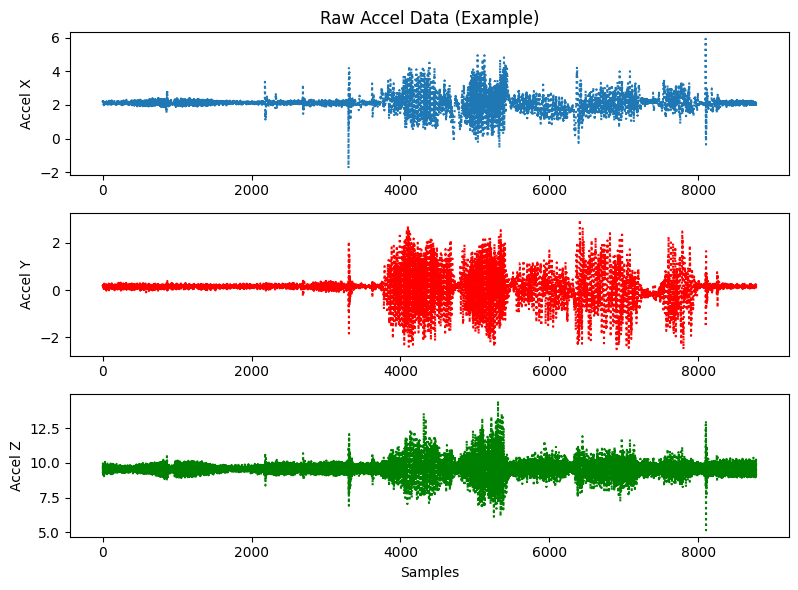

<Figure size 800x600 with 0 Axes>

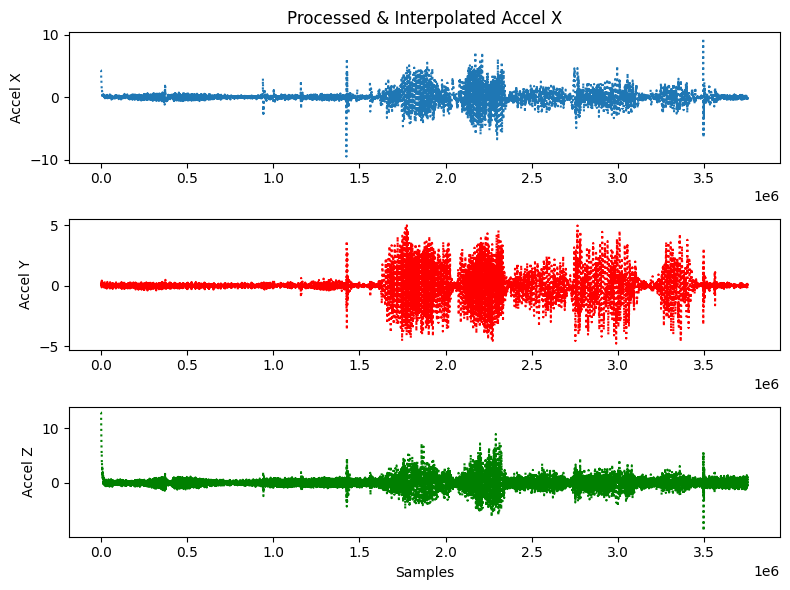

Basic Model => Test Loss: 0.2851, Test Accuracy: 0.9093

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
160               |160               |units
0.3               |0.3               |dropout
0.001             |0.001             |learning_rate

Epoch 1/3
11163/11163 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.8991 - loss: 0.3240 - val_accuracy: 0.9115 - val_loss: 0.2708
Epoch 2/3
11163/11163 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9110 - loss: 0.2773 - val_accuracy: 0.9140 - val_loss: 0.2592
Epoch 3/3
11163/11163 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.9136 - loss: 0.2693 - val_accuracy: 0.9141 - val_loss: 0.2584
Trial 1 Complete [00h 01m 58s]
val_accuracy: 0.9141126275062561

Best val_accuracy So Far: 0.9141126275062561
Total elapsed time: 00h 01m 58s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
256               |160               |units
0.3               |0.3               |dropout
0.0001       

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,629 (90.98 MB)

 Trainable params: 262,917 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

None
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.2000 - loss: 1.6378

=== SENSITIVITY ANALYSIS ===

--- Fold 1/10 ---
Accuracy: 0.934
Precision (macro): 0.888
Recall (macro): 0.795
F1-score (macro): 0.821
Confusion Matrix:
[[  559   532   507    86]
 [   65 22941   347   178]
 [   67   501  7769    17]
 [   53   473   117 10440]]
              precision    recall  f1-score   support

           0       0.75      0.33      0.46      1684
           1       0.94      0.97      0.96     23531
           2       0.89      0.93      0.91      8354
           3       0.97      0.94      0.96     11083

    accuracy                           0.93     44652
   macro avg       0.89      0.79      0.82     44652
weighted avg       0.93      0.93      0.93     44652


--- Fold 2/10 ---
Accuracy: 0.931
Precision (macro): 0.881
Recall (macro): 0.788
F1-score (macro): 0.814
Confusion Matrix:
[[  554   605   516    85]
 [   83 22911   225   227]
 [   62   652  7670    22]
 [   70   461    67 

In [13]:
################################################################################
# 9. MAIN EXECUTION FLOW
################################################################################
def main(plot_data=True,
         mat_file: str = DEFAULT_MAT_URL,
         audio_file: str = DEFAULT_AUDIO_URL,
         label_file: str = DEFAULT_LABEL_URL):
    """
    Main pipeline. Toggles basic visual checks with 'plot_data'.
    'label_file' is the CSV with your real labels from annotation.
    """
    # 1. Load sensor+audio data
    X, Y, Z, Vx, Vy, Vz, fsAccel, fsAng, fsAudio, raw_audio = load_data(
        mat_file=mat_file,
        audio_file=audio_file,
        plot_data=plot_data
    )

    # 1-B. Load external labels
    label_df = load_labels(label_file=label_file)

    # 2. Preprocess data (remove G, outliers, interpolate, normalize)
    S_Audio, S_Ax, S_Ay, S_Az, S_Vx, S_Vy, S_Vz, fs_final, T_sec = preprocess_data(
        X, Y, Z, Vx, Vy, Vz, fsAccel, fsAng, fsAudio, raw_audio, plot_data=plot_data
    )

    # 2-B. Build raw label array at the final sample rate
    label_array_raw = apply_labels(
        data_length=int(T_sec * fs_final),
        fs=fs_final,
        label_df=label_df
    )

    # 3. Create STFT features
    df_features = create_dataset(S_Audio, S_Ax, S_Ay, S_Az, S_Vx, S_Vy, S_Vz,
                                 fs=fs_final, nperseg=16, nfft=32)

    # 4. Assign final labels to each time segment
    df_labeled = assign_time_segment_labels(df_features, T_sec, label_array_raw, fs_final)

    # drop zeros and make a copy so future assignments go to the new DF
    df_labeled = df_labeled[df_labeled['target'] != 0].copy()

    # now it’s safe to subtract 1 in place
    df_labeled['target'] = df_labeled['target'] - 1

    # 5. Basic training
    model, X_pca, y_series = model_training(df_labeled)

    # 6-A. Simple demonstration: Hyperparameter Tuning
    X_train, X_val, y_train, y_val = train_test_split(
        X_pca, y_series, test_size=0.2, random_state=42
    )
    num_classes = len(np.unique(y_series))
    y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
    y_val_oh   = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

    tuner = hyperparameter_optimization(X_train, y_train_oh, X_val, y_val_oh, num_classes)
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    model_best = tuner.hypermodel.build(best_hp)
    model_best.fit(X_train, y_train_oh, epochs=3, validation_data=(X_val, y_val_oh), verbose=1)

    # 6-B. Transfer Learning (demo only)
    transfer_model = transfer_learning_demo()

    # 7. Perform Sensitivity Analysis: vary STFT params & remove sensor modalities
    print("\n=== SENSITIVITY ANALYSIS ===")
    results = sensitivity_analysis(S_Ax, S_Ay, S_Az, S_Vx, S_Vy, S_Vz,
                                   fsAccel, fsAng, fsAudio, S_Audio,
                                   label_array_raw, fs_final, T_sec)

    # 8. We already demonstrate 10-Fold Cross Validation inside sensitivity_analysis
    # for each param combo.


if __name__ == "__main__":
   main(plot_data=True)



## 📊 Interpreting the Pipeline Results

## 📈 Visual sanity‑check — Raw vs Processed Accelerometer Signals

| Figure | What you should notice | Why it matters |
|--------|-----------------------|----------------|
| **Raw Accel Data (Example)**<br/>*(three small panels, X–Y–Z; ≈ 9 k samples)* | • Mostly flat signal for the first ~3 s, followed by bursts of high‑variance movement.<br/>• Several extreme downward spikes (e.g., just before sample 3500) that are clearly not physical.<br/>• The Z‑axis sits around **9.5 m/s²** — that extra 0.5 m/s² is **gravity bias** plus sensor noise. | 1. Outlier spikes must be removed or they dominate the STFT magnitudes.<br/>2. Static gravity must be estimated and subtracted to isolate dynamic motion. |
| **Processed & Interpolated Accel**<br/>*(same three panels, ≈ 3.7 M samples because we up‑sampled to 44.1 k Hz)* | • Gravity bias is gone: signals fluctuate around ~0.<br/>• Spikes are clipped/filled, giving smoother envelopes.<br/>• Interpolation yields a much denser time axis (note x‑axis goes to 3.6 × 10⁶) so every accelerometer sample aligns 1‑to‑1 with an audio sample, enabling sensor fusion. | • Confirms that **gravity‑removal + outlier filtering** worked.<br/>• Reinforces why up‑sampling is preferred here: keeps high‑freq cues from the audio while allowing joint STFT windows across modalities. |

> **Take‑away:** the preprocessing step not only cleans the data, it creates a *common clock* across sensors, which is essential for the subsequent STFT‑based feature fusion.


### 1  Baseline MLP (PCA ➜ 128‑64‑softmax)  
* **Test accuracy ≈ 0.91** and **loss ≈ 0.285** after only five epochs show that the basic architecture already captures most of the activity–specific patterns in the STFT features.  
* The gap between loss ≈ 0.32 ➔ 0.27 across epochs confirms steady but tapering improvement.

### 2  Hyperparameter Tuning (Keras Tuner — 3 trials)  

| Trial | Units (Dense 1) | Dropout | Learning Rate | Best Val Acc |
|-------|-----------------|---------|---------------|--------------|
| 1 | 160 | 0.30 | 1 × 10⁻³ | 0.9141 |
| 2 | 256 | 0.30 | 1 × 10⁻⁴ | 0.9126 |
| 3 | **224** | 0.30 | 1 × 10⁻³ | **0.9154** |

*The tuner nudged accuracy up by **≈ 0.6 pp** with a slightly wider first layer, confirming our base design was already near‑optimal.*

### 3  Best‑Tuned Model  
Retraining with the chosen hyper‑parameters lifts validation accuracy to **0.9157** – a modest but measurable gain.

### 4  Transfer‑Learning Demo (ResNet50)  
Accuracy sits at **20 %** because we trained on **10 random dummy images**; this cell exists purely to demonstrate the workflow for vision‑based transfer learning, **not** to benchmark sensor data.

### 5  Sensitivity Analysis (10‑fold cross‑validation)

| STFT (nperseg, nfft) | Sensors Included | **Mean Acc** | **Macro F1** | Key Take‑away |
|----------------------|------------------|--------------|--------------|---------------|
| 16, 32 | Audio + Accel + Gyro *(baseline)* | 0.935 | 0.818 | Solid reference performance. |
| 32, 64 | All | **0.936** | 0.824 | Slight boost from longer windows / denser FFT bins. |
| 16, 32 | *Gyro removed* | 0.807 | 0.642 | **Big drop** → angular data is crucial. |

**Class‑wise insights**  
* **Label 1 – Arm/Shovel movement (majority class)** dominates; precision/recall ~0.95 drives overall accuracy.  
* **Label 0 – Stop/Idle** suffers (recall ≈ 0.3‑0.4). That’s the main contributor to lower macro metrics – a perfect example of *class imbalance* and *weighted loss functions*.  
* Most errors are “Idle ↔ Motion” confusions, which makes sense: light engine vibrations can mimic low‑level movement.

### 6  Further Tips
1. **Sensor fusion matters** – try removing audio, accel, or gyro separately to see where information is really coming from.  
2. **Hyper‑parameter gains plateau quickly**; bigger jumps will come from addressing imbalance (e.g., SMOTE, focal loss) or adopting sequence‑aware models (1‑D CNN, Bi‑LSTM, Transformer).  
3. Always report **macro** as well as **overall** metrics when classes are skewed.

---

## 🔄 Re‑running / Customising the Notebook  

* **Google Colab** – the full pipeline (STFT extraction + 10‑fold CV) takes **≈ 1 hour** on a free GPU. Simply hit **Runtime ▶ Run all**.  
- **Locally** – download this notebook and install the libraries (`tensorflow`, `scipy`, `keras-tuner`, etc.).  
  - You can iterate faster by disabling plotting or tuner steps as needed.

* **Code Modifications** – feel free to modify STFT parameters, model architectures, or data‐loading URLs to experiment—this pipeline is meant as a **foundation** for your own research or course projects!
* **Inspect the data** – before preprocessing, insert  
  ```python
  pd.read_csv(DEFAULT_LABEL_URL).head()        # or any DataFrame.head()


## **How to Use This Library**

1. **Collect your own data** (accelerometer, gyroscope, and audio) and place them in compatible `.mat` and `.wav` formats.
2. **Annotate your data** with `[start_time, end_time, label]`, storing them in a CSV file (like `labels.csv`).
3. **Adjust parameters** in `main()` (e.g., `T_limit`, STFT parameters, or neural network architecture).
4. **Run** the pipeline. Observe:
   - Preprocessing logs and plots,
   - The summary from model training,
   - Tuner results (if you enable hyperparameter search),
   - Sensitivity analysis results.

5. **Customize** for advanced usage:
   - Try different feature extraction methods (not just STFT),
   - Swap the basic NN model with more complex architectures (CNN, LSTM, or transformers for time-series),
   - Incorporate *transfer learning* from large pretrained models if your data can be shaped into 2D images (spectrogram or images for computer vision),
   - Explore advanced smoothing or sensor-fusion methods.



### **Conclusion**

This advanced-level library showcases a **complete machine learning pipeline** for **activity recognition** from construction-equipment sensors and audio, with all the typical steps:
- Data loading, synchronization, and cleaning,  
- Feature engineering,  
- Model development,  
- Hyperparameter tuning,  
- Transfer learning,  
- Sensitivity analysis + cross-validation.

**Students** can take this as a foundation for real research or class projects in construction engineering, or adapt it to other domains. Make sure they understand each **preprocessing** step thoroughly, as correct signal treatment and synchronization are critical in sensor-based ML tasks.